In [1]:
%matplotlib inline

import os
import sys
from itertools import product
import numpy as np
np.set_printoptions(precision=4,suppress=True, linewidth=140)
import scipy

import matplotlib.pyplot as plt

from h5 import HDFArchive
from triqs.gf import *
from triqs.gf.descriptors import Fourier, Omega
from triqs.plot.mpl_interface import plt,oplot
from triqs.lattice.utils import TB_from_wannier90, k_space_path

import solid_dmft.postprocessing.plot_correlated_bands as pcb
import solid_dmft.postprocessing.maxent_sigma as sigma_maxent

Starting serial run at: 2024-05-18 15:24:40.029256


In [2]:
fermi = 12.7367
# w90 information
w90_dict = {'w90_path': './data/mlwf/',
            'w90_seed': 'lco',
            'n_orb': 1,
            'mu_tb': fermi}
# plotting options
plot_dict = {'colorscheme_bands': 'Greys',
             'colorscheme_alatt': 'Spectral_r',
             'colorscheme_kslice': 'Spectral_r'}

tb_dict = {'bands_path': [('G', 'S\''), ('S\'', 'X'), ('X', 'G'), ('G', 'Z')], 'n_k': 50,
            'G': [ 0.0,  0.0,  0.0], 'S\'': [0.25, -0.25, 0.25], 'X': [0.0,  0.0,  0.5 ], 'Z': [0.25,  0.25, -0.25] }

# Phase diagram exploration

You might have noticed that our resulting spectral function of La2CuO4 does not show the experimental measured gap of ~2 eV [PRB 37 7506 (1988)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.37.7506), and is indeed metallic. As shown in [doi.org/10.1103/PhysRevB.91.125142](https://doi.org/10.1103/PhysRevB.91.125142) the static Coulomb interaction is too small to open a gap in our current model. To capture interactions beyond the static limit one has to solve the problem with a frequency-dependent interaction, or one can artificially increase the interaction strength to model the same behavior. For simplicity, we will follow here the latter route and change the interaction parameter $U$ to find the MIT and a correct gap of ~2 eV.


<i class="fa fa-gear fa-2x" style="color: #186391"></i>&nbsp; increase the value of $U$ in the DMFT input file `dmft_config.toml` and the `jobname` to find the gapped regime of the metal-insulator transition. Compare the k-integrated spectral function.

Tip: to speed up convergence, you can load a previous self-energy by using the config flag `load_sigma=true` and pointing to a previous calculation with `path_to_sigma='b10-U3.6/lco_wannier.h5'`. 

Tip: you can copy whole jupyter cells from the first notebook here and just change the $U=3.6$ eV to whatever $U$ you used

In [3]:
# increasing U to 5.0 results in an appropriate sized gap

In [4]:
!cat b10-U5.0/observables_imp0.dat

 it |         mu | G(beta/2) per orbital |  orbital occs up+down |      impurity occ
  0 |   12.79717 |              -0.32562 |               0.99991 |           0.99991
  1 |   12.91122 |              -0.05522 |               1.00106 |           1.00106
  2 |   12.91050 |              -0.03159 |               1.00083 |           1.00083
  3 |   12.90731 |              -0.01743 |               1.00037 |           1.00037
  4 |   12.90569 |              -0.00838 |               1.00217 |           1.00217
  5 |   12.89559 |              -0.00498 |               1.00200 |           1.00200
  6 |   12.88632 |              -0.00280 |               1.00188 |           1.00188
  7 |   12.87752 |              -0.00175 |               1.00038 |           1.00038
  8 |   12.87581 |              -0.00170 |               1.00048 |           1.00048
  9 |   12.87348 |              -0.00262 |               1.00068 |           1.00068
 10 |   12.87031 |              -0.00198 |               1.00050 

In [5]:
with HDFArchive('b10-U5.0/lco_wannier.h5','r') as h5:
    # the next two lines load all directly measured observables and the convergence metrics per iteration
    obs = h5['DMFT_results/observables']
    conv_obs = h5['DMFT_results/convergence_obs']
    # The next lines load the last iteration impurity Green's function and self-energies
    Sigma_imp_iw = h5['DMFT_results/last_iter/Sigma_freq_0']
    G_imp_iw = h5['DMFT_results/last_iter/Gimp_freq_0']
    G_imp_tau = h5['DMFT_results/last_iter/Gimp_time_0']
    # last, the chemical potential and double counting potential
    mu = h5['DMFT_results']['last_iter']['chemical_potential_post']
    dc = h5['DMFT_results']['last_iter']['DC_pot']

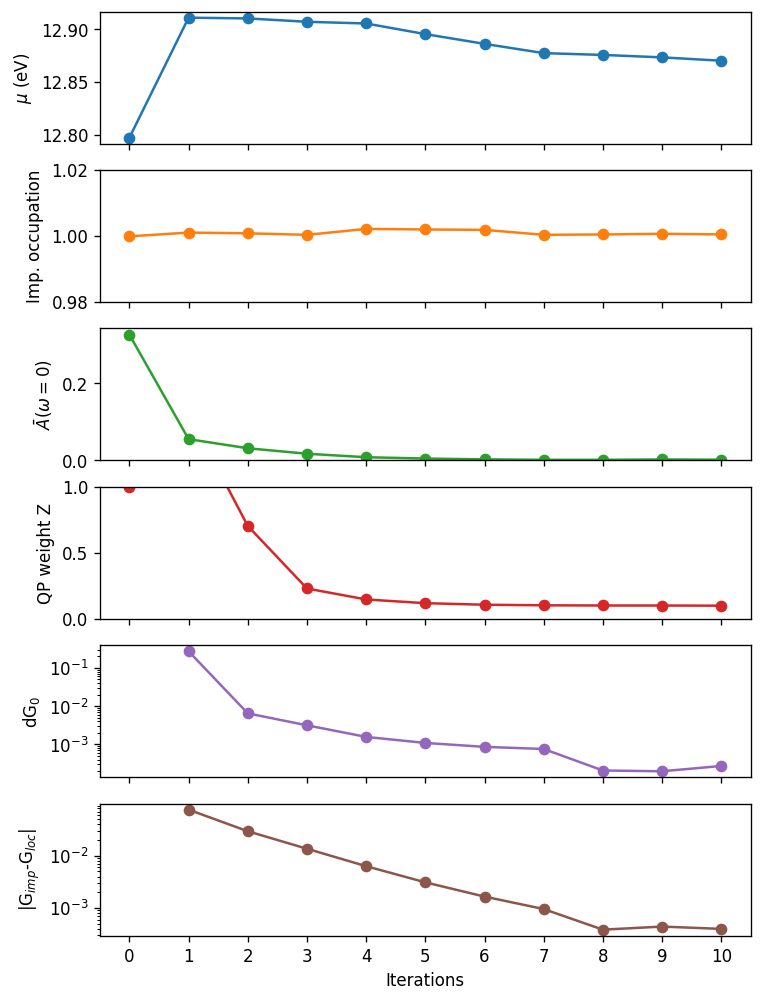

In [6]:
fig, ax = plt.subplots(nrows=6, dpi=120, figsize=(7,10), sharex=True)

# chemical potential
ax[0].plot(obs['iteration'], obs['mu'], '-o', color='C0')
ax[0].set_ylabel(r'$\mu$ (eV)')

# imp occupation
imp_occ = np.array(obs['imp_occ'][0]['up'])+np.array(obs['imp_occ'][0]['down'])
ax[1].plot(obs['iteration'], imp_occ, '-o', color='C1')
ax[1].set_ylim(0.98,1.02)
ax[1].set_ylabel('Imp. occupation')

# A(w=0)
Aw0 = -1*(np.array(obs['imp_gb2'][0]['up'])+np.array(obs['imp_gb2'][0]['down']))
ax[2].plot(obs['iteration'], Aw0 , '-o', color='C2')
ax[2].set_ylim(0,)
ax[2].set_ylabel(r'$\bar{A}(\omega=0$)')

# Z
Z = 0.5*(np.array(obs['orb_Z'][0]['up'])+np.array(obs['orb_Z'][0]['down']))
ax[3].plot(obs['iteration'], Z, '-o', color='C3')
ax[3].set_ylim(0,1.0)
ax[3].set_ylabel(r'QP weight Z')

# convergence of Weiss field
ax[4].semilogy(obs['iteration'][1:], conv_obs['d_G0'][0], '-o', color='C4')
ax[4].set_ylabel(r'dG$_0$')

# convergence of DMFT self-consistency condition Gimp-Gloc
ax[5].semilogy(obs['iteration'][1:], conv_obs['d_Gimp'][0], '-o', color='C5')
ax[5].set_ylabel(r'|G$_{imp}$-G$_{loc}$|')

ax[-1].set_xticks(range(0,len(obs['iteration'])))
ax[-1].set_xlabel('Iterations')

plt.show()

<i class="fa fa-gear fa-2x" style="color: #186391"></i>&nbsp; plot both the self-energy and $G(\tau)$ of the impurity. What are the characteristics of an insulating self-energy / Green's function?

> $ Im \Sigma(i \omega_n \rightarrow 0) \rightarrow \infty$ no coherent quasiparticles

> $G(\tau)$ is 0 around $\beta / 2$

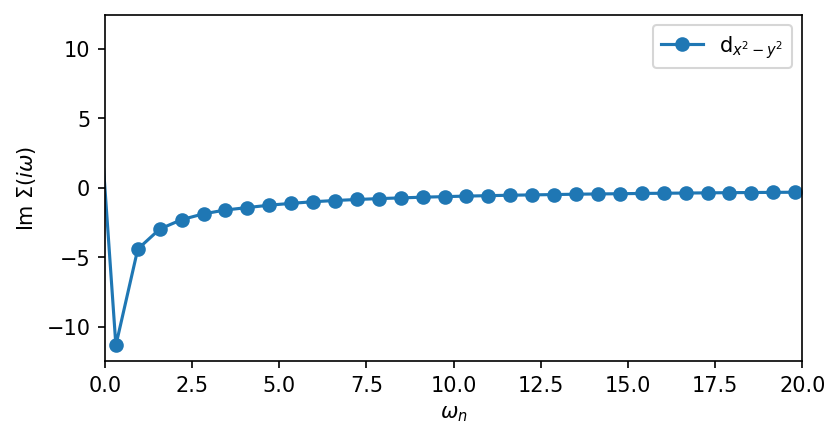

In [7]:
# plot self energy
fig, ax = plt.subplots(dpi=150, figsize=(6,3))

ax.oplot(Sigma_imp_iw['up_0'].imag, '-o', c='C0', label='d$_{x^2-y^2}$')

ax.set_ylabel(r"Im $\Sigma (i \omega)$")
ax.set_xlim(0,20)
plt.show()

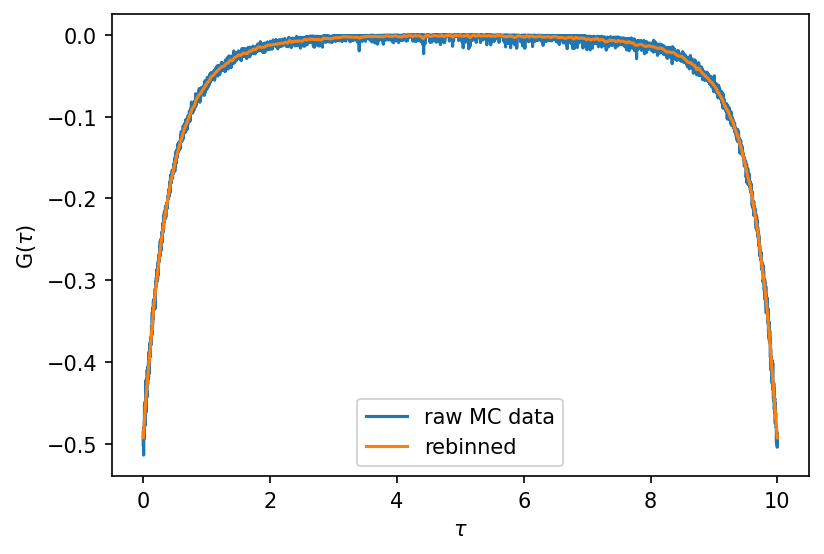

In [8]:
# plot G(tau)
fig, ax = plt.subplots(dpi=150, figsize=(6,4))

ax.oplot(G_imp_tau['up_0'].real, '-', c='C0', label='raw MC data')

G_imp_rebinned = G_imp_tau['up_0'].rebinning_tau(new_n_tau=300)
ax.oplot(G_imp_rebinned.real, '-', c='C1', label='rebinned')
ax.set_ylabel(r"G$ (\tau)$")

ax.legend()
plt.show()

<i class="fa fa-gear fa-2x" style="color: #186391"></i>&nbsp; How do these features translate into the real frequency self-energy? Run MaxEnt for the insulating self-energy and compare:


> The self-energy shows a jump in the real part around 0, i.e. Z=0, and both real and the imaginary part divergence to large values. The frequency range with large values of the real part of the self-energy determines basically the gap of the material induced by freezing the electron motion due to the Mott transition. This means that no electrons can be excited in this frequency range, even if the original dispersion, i.e. non interacting parts, has eigenvalues in this frequency range.

In [9]:
# use pcb maxent script to continue sigma
Sigma_real_freq = sigma_maxent.main(external_path='b10-U5.0/lco_wannier.h5', 
                                     omega_min = -10, omega_max= 10, 
                                     maxent_error=0.03, iteration= None,
                                     n_points_maxent=101,
                                     continuator_type='inversion_sigmainf')[0][0]

Finished reading h5 archive. Found 1 impurities.
Created sigma continuator of type "inversion_sigmainf"
Starting run of maxent now.
Continuing impurities with blocks:
- Imp 0: ['down_0', 'up_0']
appending
appending
Optimal alphas, block (0, 'down_0'):
--- Real part ---
[[39]]
Optimal alphas, block (0, 'up_0'):
--- Real part ---
[[39]]
Extracting Σ(ω) now with 1 process(es).
Writing results to h5 archive now.
Finished writing Σ(ω) to archive.

Task     | Duration (s)
-----------------------
Reading  |     0.0612
MaxEnt   |     6.4295
Extract. |    18.0882
Writing  |     0.0269
-----------------------
Total    |    24.6057



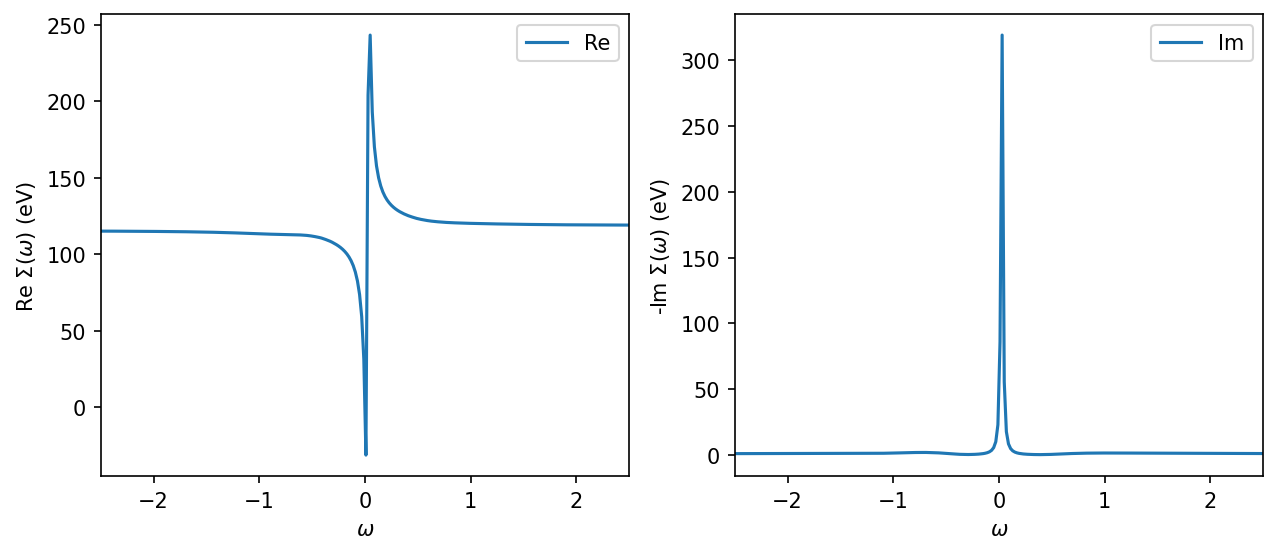

In [10]:
fig, ax = plt.subplots(1,2, sharex=True, dpi=150, figsize=(10,4))

# plot real part of the self-energy and subtract constant offset at 0.0 (Hartree shift)
# Sigma_real_freq['up_0'](0.0) evaluates the self-energy at w=0.0
ax[0].oplot((Sigma_real_freq['up_0'] - Sigma_real_freq['up_0'](0.0)[0,0]).real, '-', c='C0', label='Re')
# plot imaginary part of the self-energy
ax[1].oplot(-1*Sigma_real_freq['up_0'].imag, '-', c='C0', label='Im')

ax[0].set_ylabel(r"Re $\Sigma (\omega)$ (eV)")
ax[1].set_ylabel(r"-Im $\Sigma (\omega)$ (eV)")
ax[-1].set_xlim(-2.5,2.5)
plt.show()

<i class="fa fa-gear fa-2x" style="color: #186391"></i>&nbsp; calculate the spectral function of the insulating solution and compare the gap to the experimentally observed gap of ~2 ev

H(R=0):
     12.8956
Setting Sigma from b10-U5.0/lco_wannier.h5
μ=12.8680 eV set for calculating A(k,ω)


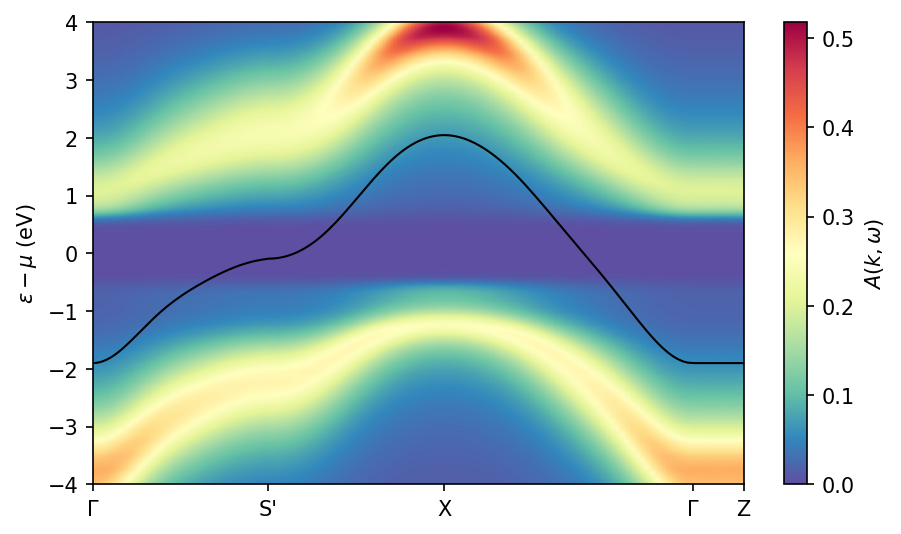

In [11]:
# we have to specify the mesh of the spectral function and pass a new keywargs object sigma_dict

w_mesh = {'window': [-4.0, 4.0], 'n_w': int(501)}
sigma_dict = {'dmft_path': 'b10-U5.0/lco_wannier.h5', 
              'it': 'last_iter', 
              'spin': 'up', 
              'block' : 0 ,
              'w_mesh': w_mesh}

tb_bands, alatt_k_w_path, freq_dict = pcb.get_dmft_bands(with_sigma='calc', 
                                                         **w90_dict, **tb_dict, **sigma_dict)

fig, ax = plt.subplots(1,dpi=150,figsize=(7,4))
pcb.plot_bands(fig, ax, alatt_k_w_path, tb_bands, freq_dict, n_orb=w90_dict['n_orb'], 
               tb=True, alatt=True, **plot_dict)

The original W90 band is plotted in black and the spectral function is shown as intensity plot. The quasiparticle band at low frequency has disappeared together with any incoherent contribution. The strong intensities at larger energies are Hubbard sattelite features forming the Hubbard bands. To visualize this effect better we now want to calculate the k-summed spectral function $A(\omega)$, which we can compare with the DOS from W90.

We first construct the full lattice Green's function:

In [12]:
# triqs function to load a w90 hamiltonian as tight binding object
TB = TB_from_wannier90(seed='lco' ,path='./data/mlwf/')

# calculate epsilon(k) on a given mesh
# since La2CuO4 is mostly 2D, we use a 2D mesh to speed things up
k_dim = 7
k_mesh = TB.get_kmesh(n_k = (k_dim, k_dim, 1))
n_k = np.prod(k_mesh.dims)
e_k = TB.fourier(k_mesh)

# create a Mesh product of k and omega mesh:
mesh_k_w = MeshProduct(k_mesh, Sigma_real_freq.mesh)

# create a triqs Gf on a combined k and omega mesh:
G_k_w = Gf(mesh = mesh_k_w, target_shape = [1,1])

# create here first a Gf called G_loc_w for the k summation
G_loc_w = Gf(mesh = Sigma_real_freq.mesh, target_shape = [1,1])

# now we loop over k-points
for k in G_k_w.mesh.components[0]:
    # use equation above to set at each k point the lattice Gf
    G_k_w[k,:] << inverse(Omega + mu - e_k[k] - (Sigma_real_freq['up_0']-dc[0]['up']) )

    # do the summation for G_loc_w  / the factor 2 is to account for both spin channels, and we divide by the weight 1/n_k
    G_loc_w << G_loc_w + 2/n_k * inverse(Omega + mu - e_k[k] - (Sigma_real_freq['up_0']-dc[0]['up']) )

In [13]:
with HDFArchive('b10-U3.6/lco_wannier.h5','r') as h5:
    Aimp_w_0_metal = h5['DMFT_results/last_iter/Aimp_maxent_0']

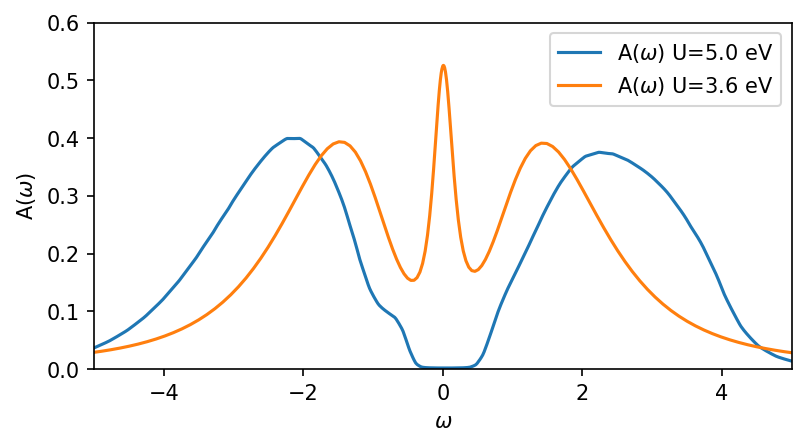

In [14]:
fig, ax = plt.subplots(1,dpi=150,figsize=(6,3))

mesh = Aimp_w_0_metal['mesh']
A_imp_w = Aimp_w_0_metal['Aimp_w_line_fit']['total_0']

ax.oplot(-1/np.pi*G_loc_w.imag, label=r'A($\omega$) U=5.0 eV')

ax.plot(mesh, A_imp_w[0,0,:].real, label=r'A($\omega$) U=3.6 eV')

ax.set_ylabel(r'A($\omega$)')
ax.set_xlabel(r'$\omega$')
ax.set_xlim(-5,5)
ax.set_ylim(0,0.6)

ax.legend()
plt.show()

The electronic gap is of the order of 1 eV, so in order to get an optical gap of 2 eV the $U$ has to be at least 5 eV.

## This concludes the second tutorial. You may now continue with tutorial 03-HubbardI-comparison.